# Week 7: Clean Midterm Notebook with a Function and Loop

### By Mica O'Brien

In this Jupyter notebook, I provide abridged code from my midterm notebooks and create a function and loop. I have removed much of the data exploration code because I don't feel that it's necessary for the purposes of this assignment. Unlike in my midterm notebooks, I use LA neighborhood geodata from the LA Times (instead of county-level neighborhood boundary data). Estefany and I are still thinking through the best way to measure distance between affordable housing developments and parks. Lastly, I create a function and loop to map affordable housing counts by neighborhood. 

In [10]:
import pandas as pd

import geopandas as gpd

import contextily as ctx

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

import matplotlib.pyplot as plt
import plotly.express as px

import folium

I start by importing my libraries.

## Data Cleaning: Affordable Housing 

I need to clean the affordable housing dataset so that it is easier to work with moving forward. In this section, I remove some unnecessary columns and rename the remaining ones. 

In [11]:
AH = gpd.read_file('Affordable_Housing_Development-Copy1.geojson')

I import the affordable housing dataset. 

In [12]:
AH.columns.to_list()

['OBJECTID', 'PROJECT_NA', 'AV_ADD', 'TOOLTIP', 'NLA_URL', 'geometry']

I list out the columns. I know that I don't need "TOOLTIP", which is essentially just a combination of the project name and address. I also don't need "NLA_URL", which is a link to the project site. 

In [13]:
columns_revised = ['OBJECTID', 'PROJECT_NA', 'AV_ADD', 'geometry']

I drop "TOOLTIP" and "NLA_URL" from the columns list, reducing my columns to 4. This will make the data easier to work with.

In [14]:
AH = AH[columns_revised]

I save my AH dataset with the revised column list.

In [15]:
AH.columns = ['object_id', 'project_name', 'av_address', 'geometry']

I rename the columns for ease moving forward. I change the names from all uppercase to all lowercase. 

## Visualizations with the Affordable Housing Dataset

Now that my affordable housing dataset is clean, I can move forward with visualizations. I start by creating an interactive map and then create a static map. Both maps tell similar stories - that affordable housing appears to be concentrated in downtown LA. Fewer affordable housing developments are showing up on the west side of the city and these developments are less densely packed. Given what we know about the NIMBYism and the influence of homeowners' associations (generally dominated by wealthy white individuals), this is not necessarily suprising. 

In [16]:
AH['lon']=AH.geometry.x
AH['lat']=AH.geometry.y 

In order to create the interactive plotly maap below, I need to create longitude and latittude columns in the datset, which I do above. 

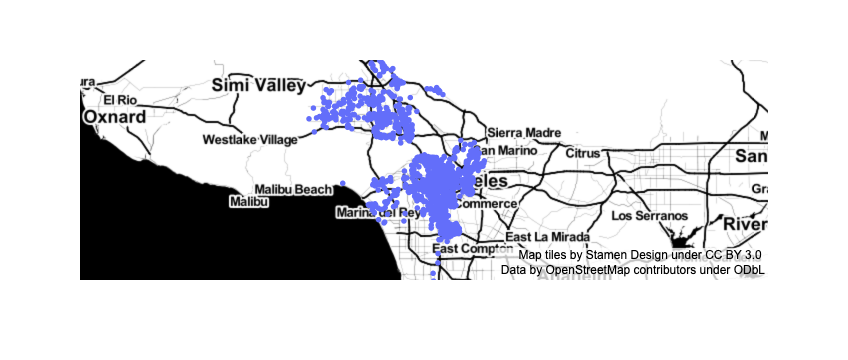

In [17]:
fig = px.scatter_mapbox(AH,
                        lat = 'lat',
                        lon = 'lon',
                        mapbox_style="stamen-toner")
fig.show()

In [18]:
fig.write_html("AH_LA_plotly.html")

Here I create my interactive map that I mention above. This map shows the distribution of affordable housing developments across the city. I think this visualization is effective because it allows the viewer to easily identify and zoom into areas with different concentrations of affordable housing. It shows us that, at least at first glance, affordable housing is unequally distributed across the city. Is this because there is greater need in some areas over others? Or is this because residents in some areas prevent affordable housing from being built in their neighborhood? 

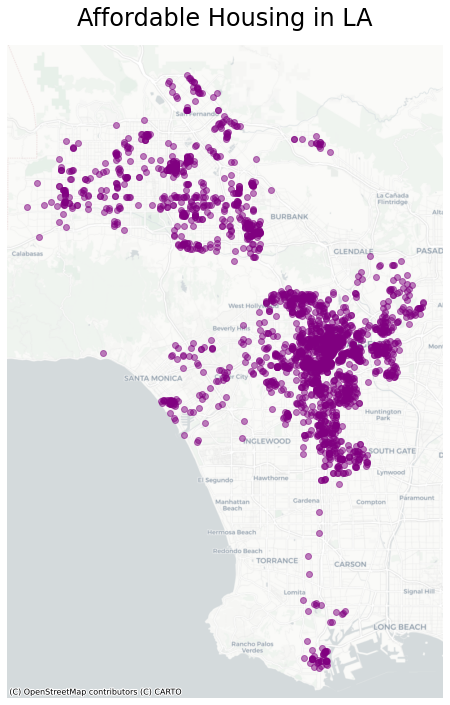

In [19]:
gdf_web_mercator = AH.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf_web_mercator.plot(
                        ax=ax, 
                        color="purple",
                        alpha=0.5
)

ax.axis('off')

ax.set_title('Affordable Housing in LA',fontsize=24,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The static map paints a similar picture. Affordable housing is clustered in central/downtown. There appear to be fewer developments on the west side of the city.

## Visualizations with the Parks Dataset 

Now I move on to the parks dataset. As I discovered during my data exploration for the midterm, the parks dataset is already clean and doesn't require any column adjustments. I plot the parks dataset with and without a base map and draw some preliminary conclusions about the distribution of greenspace across LA. 

In [20]:
Greenspace = gpd.read_file('ParkBoundaries.geojson')

I import the parks dataset. 

<AxesSubplot:>

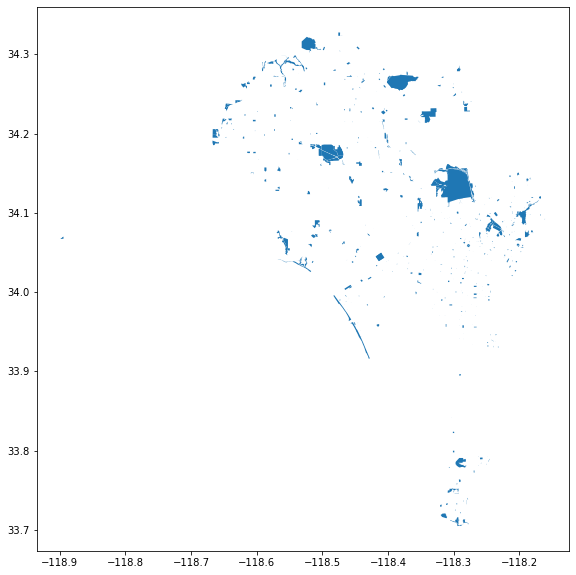

In [21]:
Greenspace.plot(figsize=(10,10))

I plot a simple map of the park polygons. While I can make a guess about which parks are reprsented by some of the larger polygons, the map is generally difficult to decipher. I need to add a base map to make better sense of where parks are located in LA. 

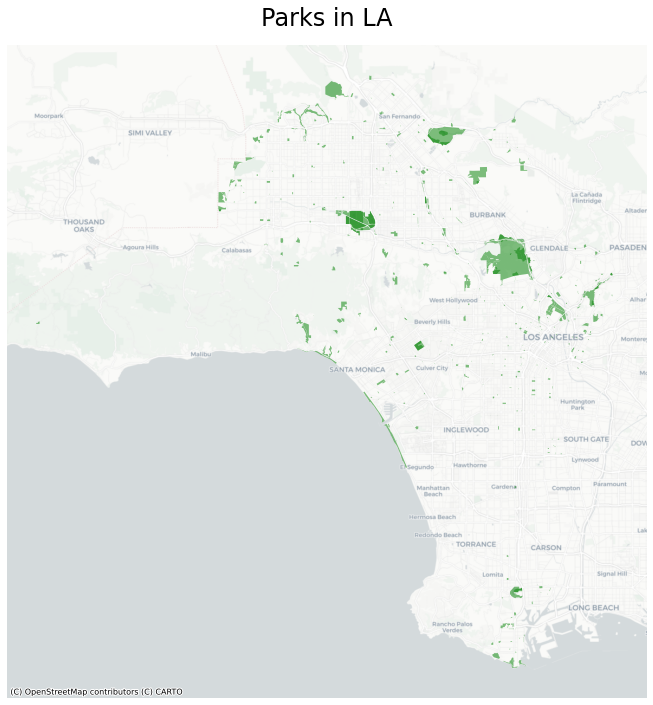

In [22]:
gdf_web_mercator = Greenspace.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf_web_mercator.plot(
                        ax=ax, 
                        color="green",
                        alpha=0.5
)

ax.axis('off')

ax.set_title('Parks in LA',fontsize=24,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [23]:
fig.write_html("Parks_LA_plotly.html")

AttributeError: 'Figure' object has no attribute 'write_html'

The base map provides helpful context. My initial takeaway from this map is that LA parks have a large range of sizes. Griffith park is the largest and is relatively centrally located. There appear to be many small parks sprinkled around downtown LA and slightly larger parks on the west side. This, however, leads me to wonder about the park-to-people ratio. Although there appear to be more parks in the downtown area, I'm curious about the populations in the east and west side of the city. In other words, downtown may have more parks, but may also have more people and more people of color. I am also curious about the quality of the parks. How does the quality of parks differ across the city? 

This dataset will need to be explored further. Estefany is focusing more on this dataset in her notebook, so I will leave my analysis here for now. 

## Overlaying Affordable Housing and Parks 

In this section, I overlay my parks and affordable housing datasets. As you'll see, Estefany and I will need to think through how best to make sense of this overlay. It's interesting to see both parks and affordable housing developments on one map, but it's hard to understand their relationship at the moment. We will be thinking through ways to quantify distance between parks and affordable housing over the next few weeks. 

In [16]:
AH = AH.to_crs(4326)
Greenspace = Greenspace.to_crs(4326)

First, I set my projections for both datasets to 4326. 

In [17]:
m = folium.Map(
    location=[34.0536909, -118.242766],
    tiles="cartodbpositron",
    zoom_start=11,
)

In [18]:
m

Then, I load in the base folium map. 

In [19]:
folium.GeoJson(AH, name="geojson").add_to(m)

In [20]:
m

I layer the affordable housing dataset on top of the folium basemap, which resembles the plotly map above. 

In [21]:
for _, r in Greenspace.iterrows():
  
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)

In [22]:
m

I overlay the parks dataset on top of the affordable housing dataset on the folium base map. It's difficult to see how the distribution of affordable housing relates to the distribution of parks. Estefany and I will be thinking about how to make this map more effective--and how to analyze the data points and polygons--in the next few weeks. 

## Visualizing Affordable Housing by Neighborhood 

In this section, I turn back to the affordable housing dataset and read in a neighborhood boundaries file from the LA Times. I used a county-wide neighborhood boundary file for the midterm, but at Chris's suggestion, decided to work with a city-wide file instead (given that the affordable housing points fall within the city of LA). I create a new column of the number of affordable housing developments by neighborhood and recreate 2 plotly bar charts. I also create a chloropleth map of affordable housing developments by neighborhood. These visualizations allow us to hone in on the neighborhoods with the highest and lowest number of affordable housing developments and substantiate our claims about the distribution of affordable housing across the city. 

In [8]:
neighborhoods2 = gpd.read_file("LA_Times_Neighborhood_Boundaries (1).geojson")

I read in the neighborhood boundary file. 

In [9]:
neighborhoods2.shape

(114, 3)

I take a look at the shape of the data. It looks like there are 114 identified neighborhoods in this dataset. 

In [10]:
AH_by_neighborhood2 = gpd.sjoin(neighborhoods2, AH) 

I join the affordable housing and neighborhood boundary files so I can calculate how many affordable housing developments fall in each neighborhood. Unlike the midterm, I join the affordable housing dataset with the neighborhoods dataset (instead of the other way around) to create ascending and descending bar graphs.

In [11]:
projects_per_community_counts2 = AH_by_neighborhood2.value_counts('name').reset_index(name='projects_per_community_counts2')
projects_per_community_counts2

name  projects_per_community_counts2
0           Westlake                             146
1           Downtown                             127
2         Pico-Union                             105
3    North Hollywood                             101
4      Boyle Heights                              98
..               ...                             ...
98          Westwood                               1
99      Porter Ranch                               1
100        Larchmont                               1
101      Playa Vista                               1
102     Shadow Hills                               1

[103 rows x 2 columns]

Next, I create a new column of number of developments per neighborhood. This allows me to easily see the neighborhood with the highest and lowest number of developments. 

In [12]:
AH_byneighborhood3 = neighborhoods2.merge(projects_per_community_counts2, how='left', on='name')

In [13]:
AH_byneighborhood3.head()

OBJECTID                    name  \
0         1         Adams-Normandie   
1         2                  Arleta   
2         3       Arlington Heights   
3         4         Atwater Village   
4         5  Baldwin Hills/Crenshaw   

                                            geometry  \
0  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   
1  POLYGON ((-118.44255 34.26412, -118.44240 34.2...   
2  POLYGON ((-118.31862 34.05306, -118.31673 34.0...   
3  MULTIPOLYGON (((-118.27886 34.15321, -118.2788...   
4  POLYGON ((-118.36102 34.02532, -118.36026 34.0...   

   projects_per_community_counts2  
0                            63.0  
1                             2.0  
2                            22.0  
3                             NaN  
4                            20.0

I merge the new counts column with the neighborhood boundary and affordable housing dataset. I take a look at the data to see how it is ordered. Right now it appears to be in alphabethical order. 

In [14]:
AH_byneighborhood3 = AH_byneighborhood3.sort_values(by='projects_per_community_counts2', ascending=False)

I re-sort the data on the "projects_per_community_counts2" variable so that the neighborhoods with the highest number of developments are listed first and the neighborhoods with the lowest number of developments are listed last. 

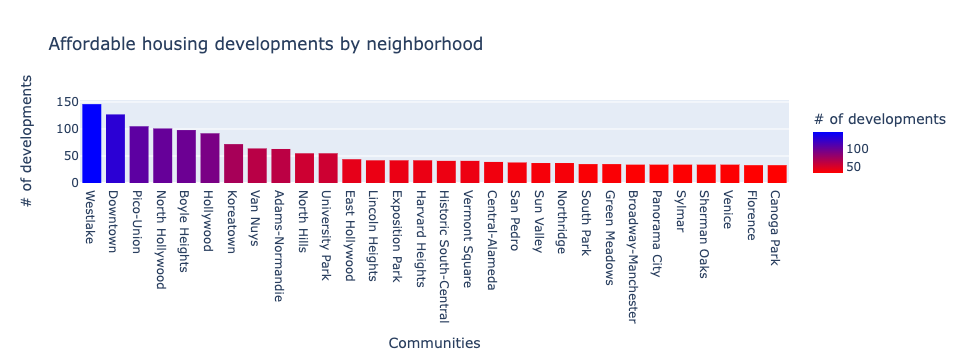

In [15]:
fig = px.bar(
        AH_byneighborhood3.head(30),
        x='name',
        y = 'projects_per_community_counts2',
       hover_data=['name', 'projects_per_community_counts2'], 
        color='projects_per_community_counts2',
        color_continuous_scale='Bluered_r',
        title='Affordable housing developments by neighborhood',
        labels={
            'name':'Communities',
            'projects_per_community_counts2':'# of developments'
        }
)

fig.update_traces(marker_line_width=0)

fig.show()

I create a plotly bar chart of the 30 neighborhoods with the highest numbers of affordable housing developments. As we saw in the maps above, neighborhoods in the downtown area--including Westlake, Downtown, Hollywood, and Koreatown--appear to have the highest numbers. 

In [16]:
AH_byneighborhood3 = AH_byneighborhood3.sort_values(by='projects_per_community_counts2', ascending=True)

I sort the data in descending order to take a closer look at the neighborhoods with the fewest number of affordable housing developments. 

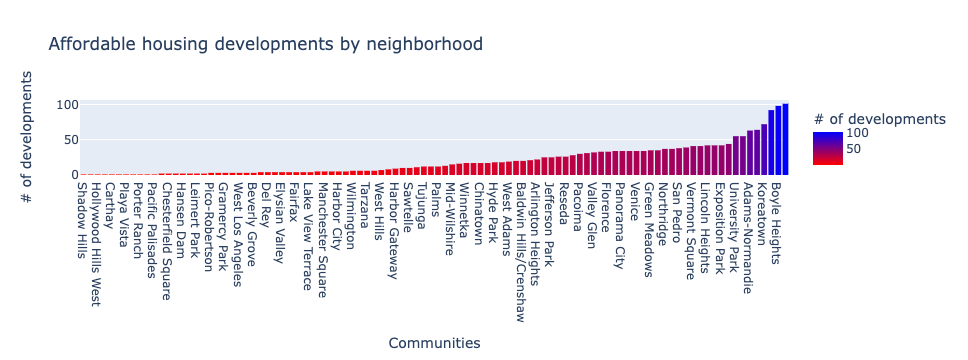

In [18]:
fig = px.bar(
        AH_byneighborhood3.head(100),
        x='name',
        y = 'projects_per_community_counts2',
       hover_data=['name', 'projects_per_community_counts2'], 
        color='projects_per_community_counts2',
        color_continuous_scale='Bluered_r',
        title='Affordable housing developments by neighborhood',
        labels={
            'name':'Communities',
            'projects_per_community_counts2':'# of developments'
        }
)

fig.update_traces(marker_line_width=0)

fig.show()

In this plotly bar graph, I can see that many neighborhoods on the west side--including Westwood, Pacific Palisades, and Brentwood--have some of the fewest affordable housing developments. Again, this is in line with the initial maps showing the dispersion of affordable housing across the city.

<AxesSubplot:>

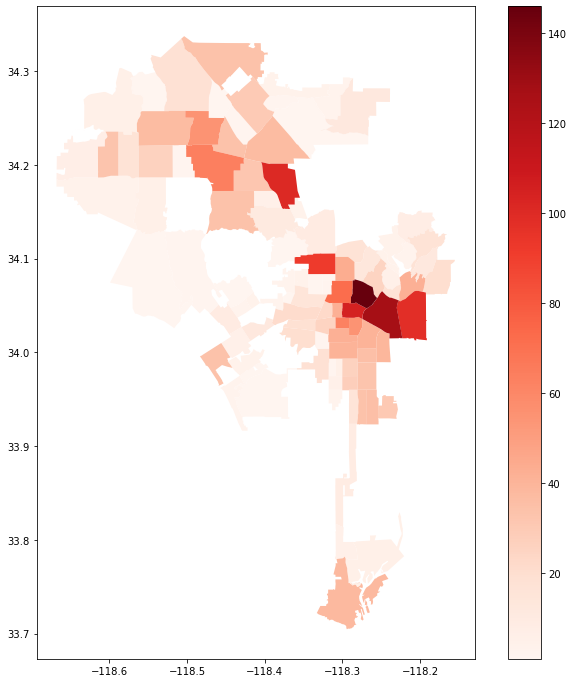

In [17]:
fig,ax = plt.subplots(figsize=(12,12))

AH_byneighborhood3.plot(ax=ax,column='projects_per_community_counts2',legend=True,cmap='Reds')

Lastly, I create a chloropleth map to visualize the data in a different way. Although it tells the viewer the same thing as the bar graphs, it allows the viewer to more easily identify clusters and trends. Several neighborhoods in the downtown area appear to have high numbers of affordable housing. Almost all of the neighborhoods on the west side, on the other hand, appear to have 20 or fewer developments. 

## Visualizing Parks by Neighborhood

I turn back to the parks dataset in this section. I follow a similar sequences as the one above, joining the affordable housing and neighborhood boundary datsets, creating a new column of park counts by neighborhood, joining the new column to the merged data, and creating a chloropleth map. The chloropleth map shows that neighborhoods with the most parks are on the perimeter of the city. The central part of the city appears to have the fewest, which is in contrast to the location of affordable housing. 

In [27]:
Parks_by_neighborhood = gpd.sjoin(neighborhoods2, Greenspace) 

I join the greenspace and neighborhood boundary datasets. 

In [36]:
parks_per_community_counts = Parks_by_neighborhood.value_counts('name_left').reset_index(name='parks_per_community_counts')
parks_per_community_counts.head(30)

name_left  parks_per_community_counts
0           San Pedro                          21
1       Boyle Heights                          17
2              Venice                          16
3          West Hills                          14
4       Highland Park                          13
5   Pacific Palisades                          13
6       Griffith Park                          12
7          Chatsworth                          12
8        Porter Ranch                          11
9             Pacoima                          10
10    Sepulveda Basin                          10
11           Westlake                          10
12  Montecito Heights                          10
13         Wilmington                          10
14              Watts                           9
15          Hollywood                           9
16             Encino                           9
17         Sun Valley                           9
18    Lincoln Heights                           8
19          Echo Park                           8
20     Woodland Hills                           8
21        Studio City                           8
22      Granada Hills                           8
23            Tujunga                           8
24         Eagle Rock                           7
25           Downtown                           7
26        Silver Lake                           7
27        Valley Glen                           7
28    Central-Alameda                           7
29    Hollywood Hills                           7

I create the new column of number of parks per neighborhood. I expect many neighborhoods to have one or two. San Pedro appears to have the most. 

In [29]:
Parks_by_neighborhood = Parks_by_neighborhood.merge(parks_per_community_counts, how='left', on='name_left')

In [35]:
Parks_by_neighborhood['name_left'==Pacific Palisades]

SyntaxError: invalid syntax (2008546490.py, line 1)

I join the new counts column to the merged data so that I can create my chloropleth map below. 

<AxesSubplot:>

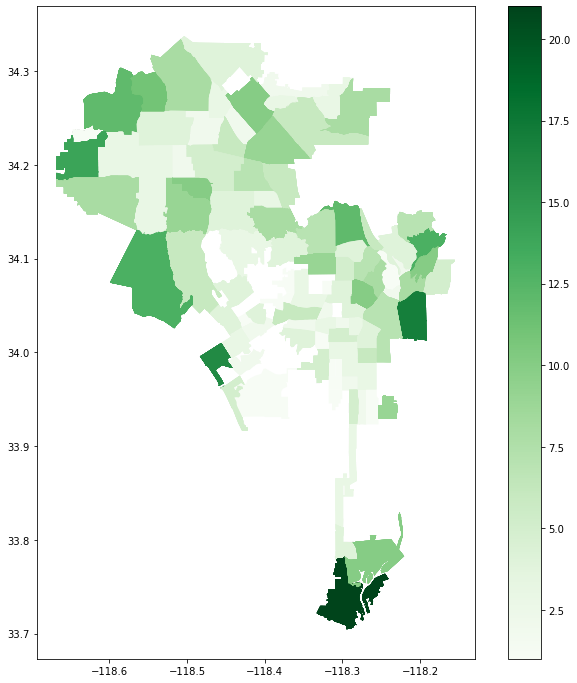

In [37]:
fig,ax = plt.subplots(figsize=(12,12))

Parks_by_neighborhood.plot(ax=ax,column='parks_per_community_counts',legend=True,cmap='Greens')

I create a chloropleth map showing the number of parks per neighborhod. San Pedro appears to have the most with over 20 parks, while neighborhoods in the central part of the city appear to have the fewest. In looking at this and the other chloropleth map, we can see that the distribution of affordable housing does not match the distribution of parks. While affordable housing is concentrated in central/downtown LA, parks are concetrated along the outskirts of the city. 

## Function and Loop

I wanted an easy way to pull visualizations of the number of affordable housing developments by neighborhood, so I created a function and loop that allows me to produce a seperate map for each neighborhood. Estefany and I are thinking about honing in on a few neighborhoods for our final project. I think this function will help us do this. This function and loop also helped me see that there are many neighborhoods in LA that have no affordable housing. These neighborhoods produce blank gray squares. 

In [18]:
gdf_web_mercator = AH_byneighborhood3.to_crs(epsg=3857)

I start by bringing in my code for web mercator and setting my projection to 3857. 

In [19]:
def AH_across_neighborhoods(place):    
    
    fig,ax = plt.subplots(figsize=(10,10))
    
    gdf_web_mercator[gdf_web_mercator.name ==place].plot(ax=ax,
                            column='projects_per_community_counts2',
                            cmap='YlGn',
                            legend=True, 
                            vmin = 0, 
                            vmax = 150)

    ax.set_title('Affordable housing in ' + place)

    ax.axis('off')
    
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=10)

I define my function above and set the legend minimum and maximum so that the colors are consistent across all maps. 

In [28]:
neighborhoods = ['Bel-Air', 'Westlake', 'Boyle Heights','San Pedro', 'Pacific Palisades']

I select the first 11 neighborhoods to loop through. I feel that they provide a nice array of types of neighborhoods across the city. I can of course go back and add/takeaway neighborhoods as needed.

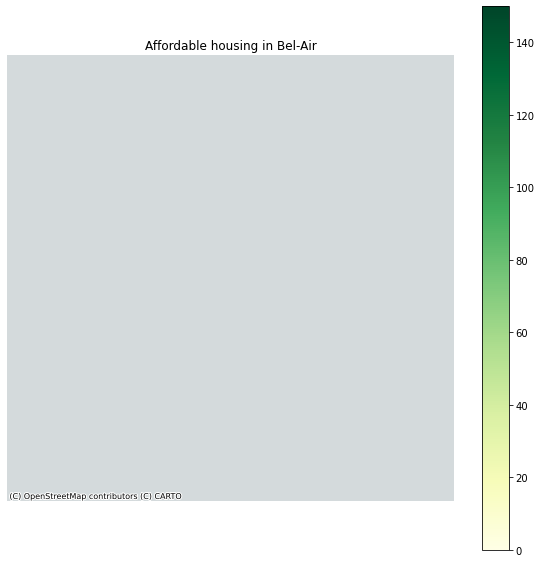

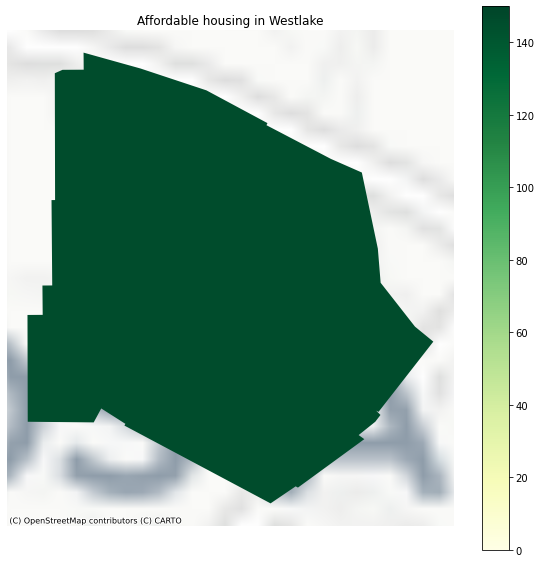

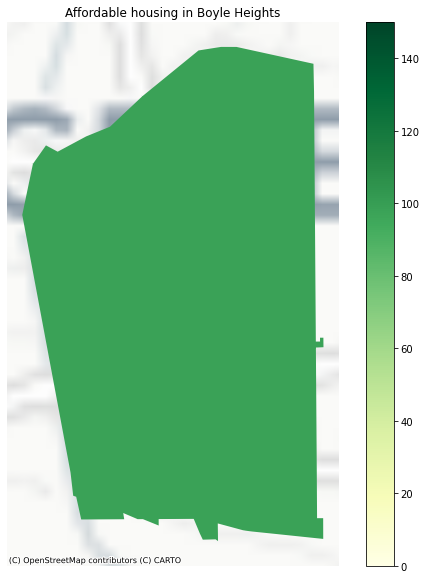

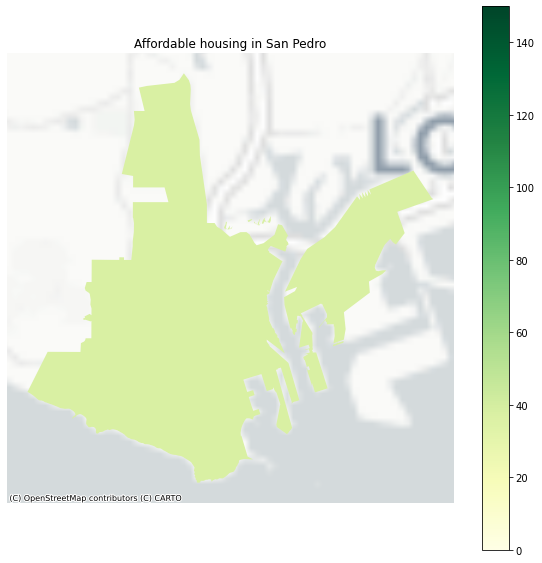

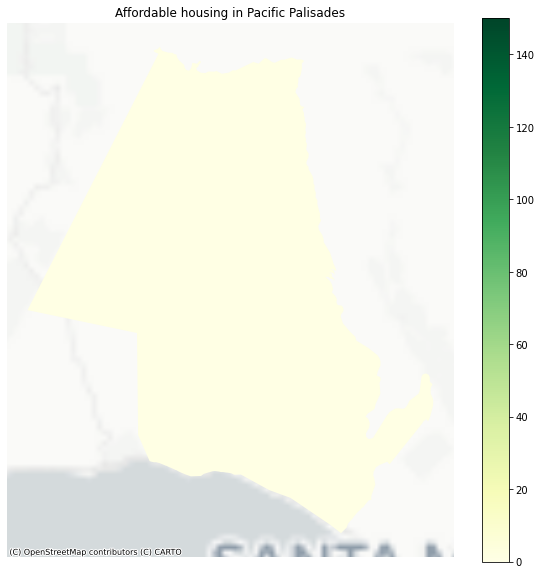

In [29]:
 for neighborhood in neighborhoods: 
        AH_across_neighborhoods(place=neighborhood)

These 11 graphs show the range in numbers of affordable housing developments across neighborhoods. Beverlywood, Beverly Crest, Bel-Air, and Atwater Village have no affordable housing. Brentwood, Beverly Grove, Baldwin Hills/Crenshaw, Arlington Heights, and Arleta have around 20 affordable housing developments. Adams-Normandie has between 60 and 80. Lastly, Boyle Heights has 80+. Again, thes distributions are in line with what we observe in the chloropleth maps and bar charts. In terms of next steps, it might be interesting to group the neighborhoods by number of affordable housing developments and identify commonalities difference. Estefany and I can also use this loop to identify 2-4 contrasting neighborhoods to focus on for the next phase of the project.  

## Distribution of Work

Mica and Estefany submitted 2 seperate notebooks. Mica focused on merging the affordable housing and greenspace datasets and creating a function and loop related to affordable housing by neighborhood. Estefany focused on racial demographics by census tract and access to greenspace. 